In [185]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from keras.preprocessing.image import ImageDataGenerator

# Import umap
import umap

# Load features 2d
grouped = np.load('features_clip_val.npy', allow_pickle=True)

features_val, labels_val, filenames = zip(*grouped)

features_val = np.array(features_val)
labels_val = np.array(labels_val)
filenames = np.array(filenames)

# l2 normalize
#features_val /= np.linalg.norm(features_val, axis=1, keepdims=True)

print(features_val.shape)

(4700, 1024)


In [198]:
import torch
import open_clip
import csv
import os

MAIN_ROUTE = 'SimilarImages'
CLASES = 'objetos.csv'
PROMPT = 'a picture of a {}, a type of domestic waste'
K = 5
CLASES_NAME = os.listdir(MAIN_ROUTE)

model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s34b_b88k')
model.cuda()

tokenizer = open_clip.get_tokenizer('ViT-g-14')

with open(CLASES, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    clases = list(reader)

eng_sub_clases = [clase[1] for clase in clases]
esp_sub_clases = [clase[0] for clase in clases]
clases = [clase[2] for clase in clases]

final_promps = [PROMPT.format(promp2).lower() for promp2 in eng_sub_clases]
with torch.no_grad(), torch.cuda.amp.autocast():
    final_promps = tokenizer(final_promps)
    text_features = model.encode_text(final_promps.to('cuda'), normalize=False)

In [202]:
text_features = text_features.cpu().numpy()

In [218]:
# tsne
umap_ = umap.UMAP(n_components=2, n_neighbors=25, min_dist=0.5, metric='cosine')
umap_.fit(features_val)
features_val_umap = umap_.transform(features_val)
features_text_umap = umap_.transform(text_features)

In [219]:
# Labels to int
labels = labels.astype(int)

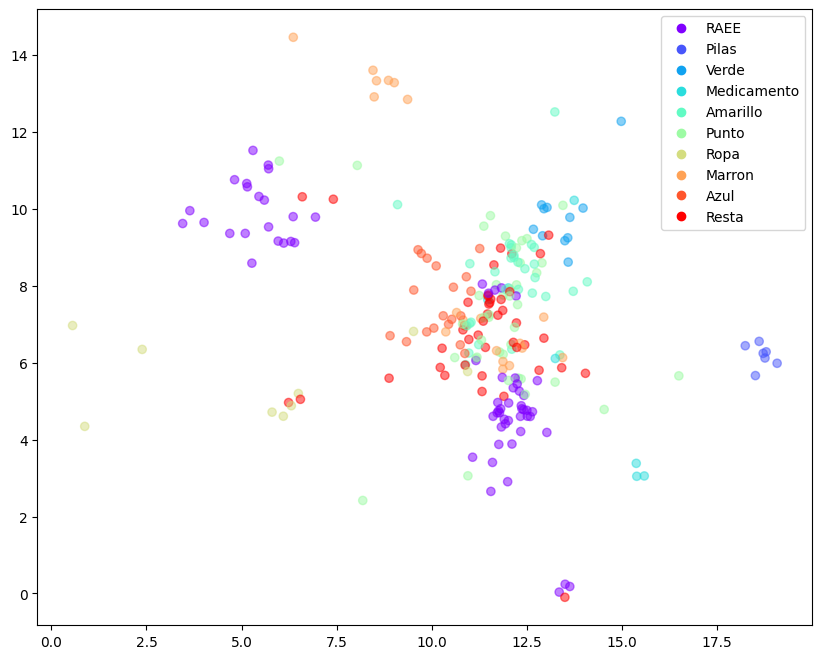

In [231]:
# Obtener las clases únicas y asignar un color único a cada una
unique_clases = list(set(clases))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clases)))
color_dict = dict(zip(unique_clases, colors))

# Asignar a cada punto su correspondiente color basado en su clase
point_colors = [color_dict[clase] for clase in clases]

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))
plt.scatter(features_text_umap[:, 0], features_text_umap[:, 1], c=point_colors, alpha=0.5)

# Opcionalmente agregar una leyenda
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in colors]
plt.legend(markers, unique_clases, numpoints=1)

plt.show()

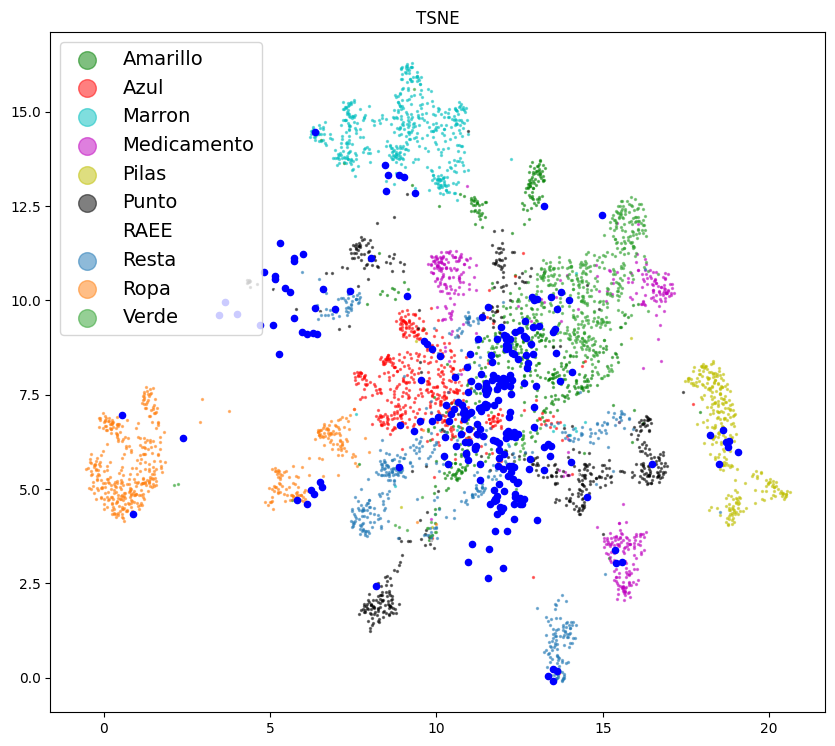

In [243]:

# Plot scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.2)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

scatter_plots = []

for i in range(len(CLASES_NAME)):
    scatter_plots.append(ax.scatter(features_val_umap[labels_val == i, 0], features_val_umap[labels_val == i, 1], c=colors[i+1], s=2, alpha=0.5))
scatter_plots.append(ax.scatter(features_text_umap[:, 0], features_text_umap[:, 1], c=colors[0], s=20))

# Legend size points bigger
ax.legend(scatter_plots, CLASES_NAME, loc='upper left', fontsize=14, markerscale=9)



ax.set_title('TSNE')
plt.show()

In [7]:
# Save features 3d
np.save('features_clip_2d_val.npy', features_2d)

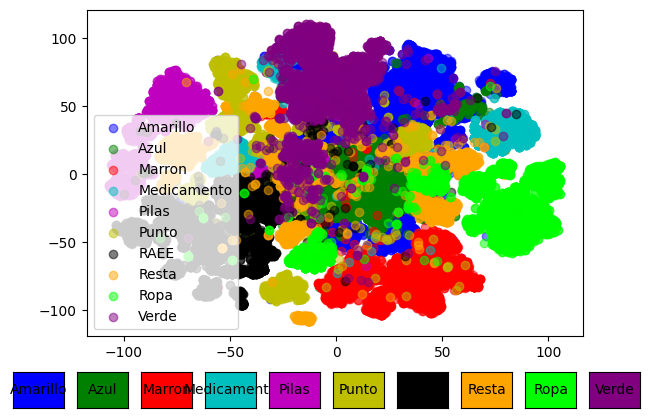

In [9]:

# Plot scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.2)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'lime', 'purple']

y_true = labels_val
labels = y_true
classes_names = os.listdir('Final_dataset_small/Validation')
scatter_plots = []

# Show clases names in legend and create button to show/hide classes
for i in range(len(classes_names)):
    idx = labels == i
    sc = ax.scatter(features_2d[idx, 0], features_2d[idx, 1], c=colors[i], label=classes_names[i], alpha=0.5)
    scatter_plots.append(sc)

ax.legend()

def on_button_click(event):
    for idx, button in buttons.items():
        if button.ax == event.inaxes:
            label = idx
            break
    sc = scatter_plots[label]
    sc.set_visible(not sc.get_visible())  # Muestra u oculta la clase
    plt.draw()

# Crea los botones para mostrar y ocultar las clases
buttons = {}
for i in range(10):
    button_ax = plt.axes([0.01 + i * 0.1, 0.05, 0.08, 0.075])
    button = Button(button_ax, classes_names[i], color=colors[i], hovercolor='0.7')
    button.on_clicked(on_button_click)
    buttons[i] = button

plt.show()